# library

In [1]:
import subprocess
import platform
from glob import glob 

import ast 

import pandas as pd
import numpy as np
import networkx as nx
from shapely.geometry import Point, Polygon, mapping
import os
import geopandas
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go

# Generate visual links

## Geometry creation

- To load elements of building layouts from .dxf files in the SourceData folder, and convert them to geometries.
- Annotations and walls are used for visualisation.
- Seats and beds are used for analysis and establishing co-awareness networks.

Number of Seats:  20
Number of Beds:  3


0     Text(2713.070894242297, -895.256176811243, 'B1')
1    Text(4913.070894242297, -895.2561768112421, 'B2')
2       Text(9513.0708942423, -895.256176811243, 'B3')
dtype: object

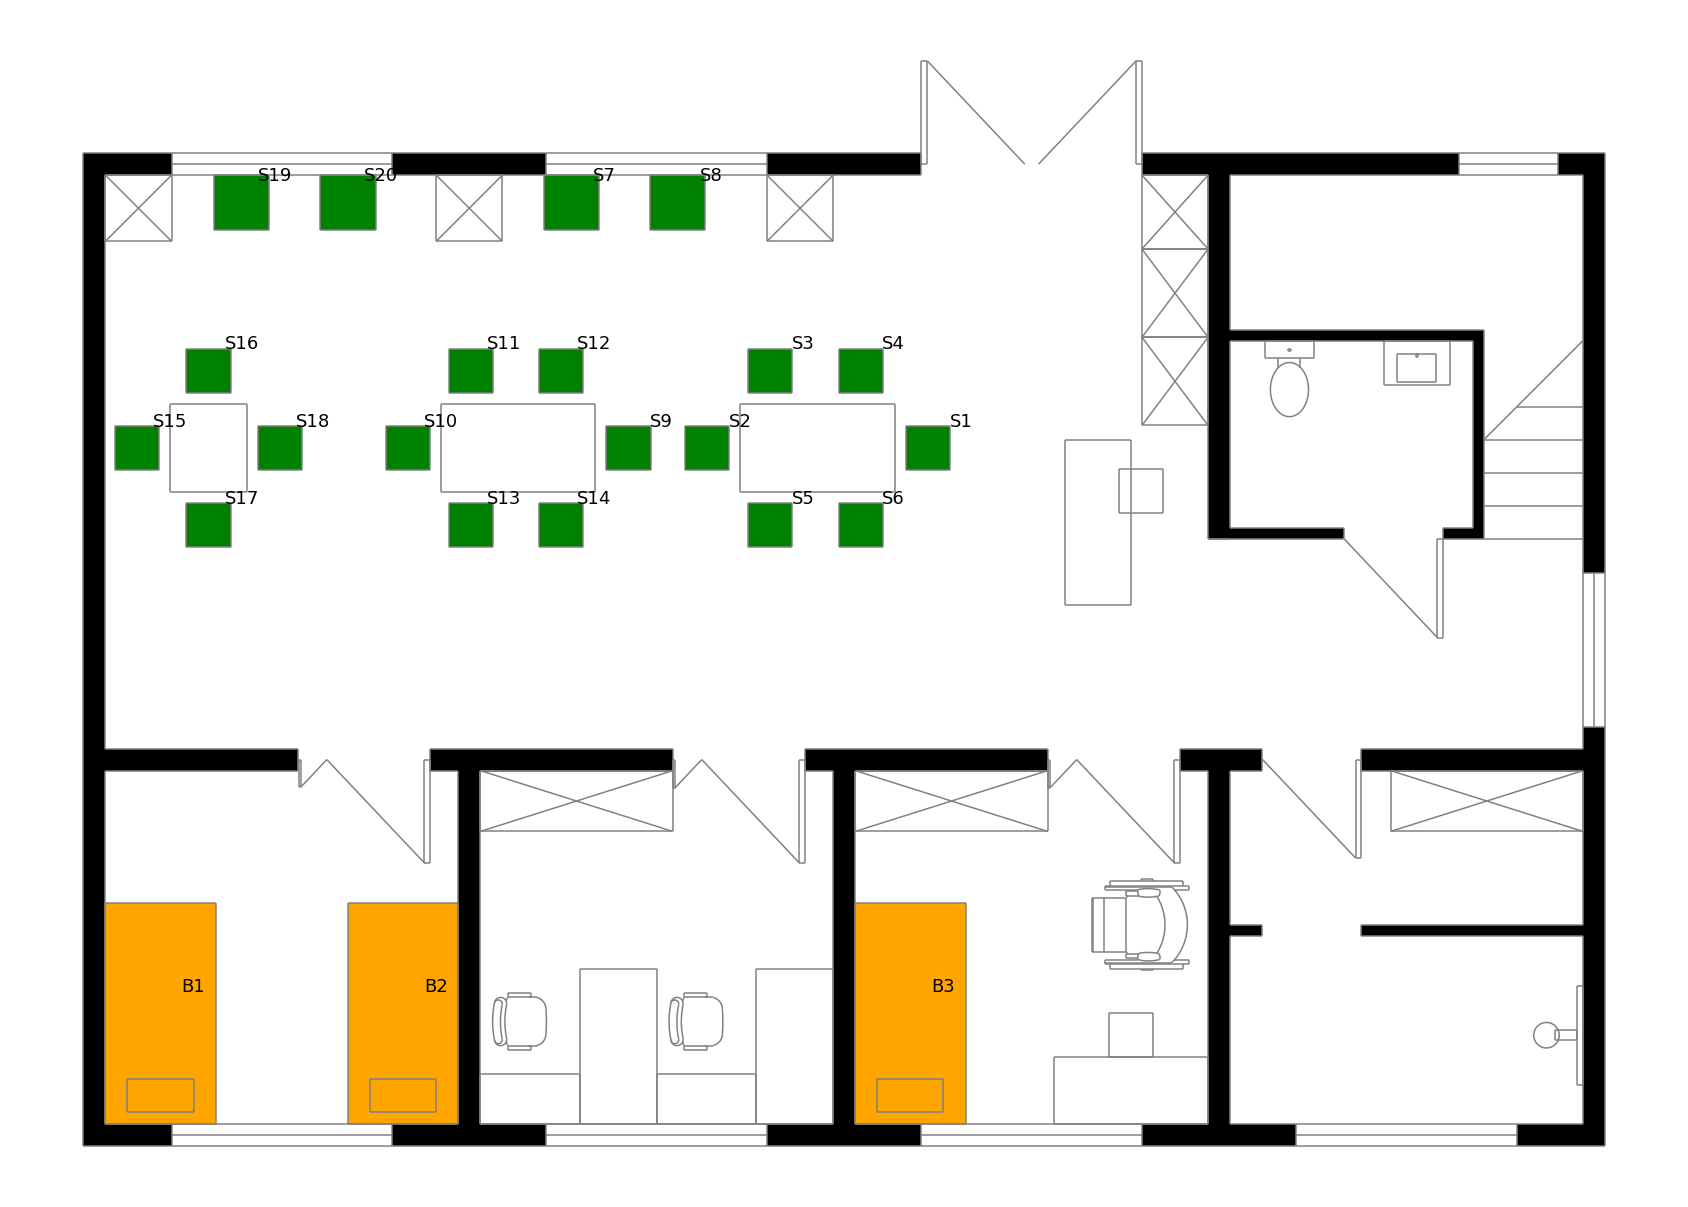

In [2]:
# load building layout (seat, bed, wall, annotation) from .dxf files and convert to geometries

faci = 'F1'

# load seats
Seat = geopandas.read_file(f'Data/SourceData/{faci}_seat.dxf')
Seat['geometry'] = [Polygon(mapping(x)['coordinates']) for x in Seat.geometry] # concert to polygon
Seat['OID'] = Seat.index.to_series().apply(lambda x: 'S' + str((x+1)))  # specify seat id
print('Number of Seats: ', Seat.shape[0])
Seat.to_file(f'Data/{faci}_seat.gpkg', driver='GPKG') # save to gpkg

# load beds
Bed = geopandas.read_file(f'Data/SourceData/{faci}_bed.dxf')
Bed['geometry'] = [Polygon(mapping(x)['coordinates']) for x in Bed.geometry]
Bed['OID'] = Bed.index.to_series().apply(lambda x: 'B' + str((x+1)))  # specify bed id
print('Number of Beds: ', Bed.shape[0])
Bed.to_file(f'Data/{faci}_bed.gpkg', driver='GPKG') # save to gpkg

# load walls
Wall = geopandas.read_file(f'Data/SourceData/{faci}_wall.dxf')
Wall['geometry'] = [Polygon(mapping(x)['coordinates']) for x in Wall.geometry] # convert to polygon
Wall.to_file(f'Data/{faci}_wall.gpkg', driver='GPKG') # save to gpkg

# load annotations
Annot = geopandas.read_file(f'Data/SourceData/{faci}_annot.dxf')
Annot.to_file(f'Data/{faci}_annot.gpkg', driver='GPKG') # save to gpkg


# plot layout plan
fig,ax = plt.subplots(figsize=(30,30))
ax.axis('off')
ax.set_aspect('equal')

Seat.plot(ax=ax, color='green')
Bed.plot(ax=ax, color='orange')
Wall.plot(ax=ax, color='black')
Annot.plot(ax=ax, color='gray')

# plot seat id
Seat.apply(
    lambda x: ax.text(
        s=x['OID'],
        x=list(x['geometry'].centroid.coords[0])[0]+300,
        y=list(x['geometry'].centroid.coords[0])[1]+200,
        fontsize=18,
        horizontalalignment='center'
    ),
    axis=1
)
# plot bed id
Bed.apply(
    lambda x: ax.text(
        s=x['OID'],
        x=list(x['geometry'].centroid.coords[0])[0]+300,
        y=list(x['geometry'].centroid.coords[0])[1]+200,
        fontsize=18,
        horizontalalignment='center'
    ),
    axis=1
)

In [3]:
# add isovist parameters (direction and view angle) to each bed and seat,
# from the .xlsx file which is prepared in advance

# concat beds and seats geometries
BS = pd.concat([Bed,Seat])

# specify isovist parameters, load .xlsx file and merge with bad and seat geometries based on ids
iso_param = pd.read_excel(f'Data/SourceData/{faci}_ISO_params.xlsx')
BS = pd.merge(
    BS, iso_param,
    left_on='OID',
    right_on='OID',
    how='left'
)
BS.to_file(f'Data/{faci}_BS.gpkg', driver='GPKG') # save to gpkg
BS

,Layer,PaperSpace,SubClasses,Linetype,EntityHandle,Text,geometry,OID,angle,viewangle
0,bed,None,AcDbEntity:AcDbPolyline,None,68,None,"POLYGON ((2913.071 -95.256, 1913.071 -95.256, ...",B1,180,360
1,bed,None,AcDbEntity:AcDbPolyline,None,69,None,"POLYGON ((4113.071 -95.256, 5113.071 -95.256, ...",B2,180,360
2,bed,None,AcDbEntity:AcDbPolyline,None,6A,None,"POLYGON ((9713.071 -95.256, 8713.071 -95.256, ...",B3,180,360
3,seat,None,AcDbEntity:AcDbPolyline,None,68,None,"POLYGON ((9170.911 3831.119, 9570.911 3831.119...",S1,180,180
4,seat,None,AcDbEntity:AcDbPolyline,None,69,None,"POLYGON ((7570.911 3831.119, 7170.911 3831.119...",S2,0,180
5,seat,None,AcDbEntity:AcDbPolyline,None,6A,None,"POLYGON ((7743.705 4531.119, 8143.705 4531.119...",S3,270,180
6,seat,None,AcDbEntity:AcDbPolyline,None,6B,None,"POLYGON ((8562.434 4531.119, 8962.434 4531.119...",S4,270,180
7,seat,None,AcDbEntity:AcDbPolyline,None,6C,None,"POLYGON ((7743.705 3531.119, 8143.705 3531.119...",S5,90,180
8,seat,None,AcDbEntity:AcDbPolyline,None,6D,None,"POLYGON ((8562.434 3531.119, 8962.434 3531.119...",S6,90,180
9,seat,None,AcDbEntity:AcDbPolyline,None,6E,None,"POLYGON ((5891.475 6004.744, 6391.475 6004.744...",S7,270,180


## Isovists generation

- Generate isovists for each bed and seat using DepthmapX CLI.

In [4]:
# selects the correct depthmapXcli from the lib folder

if platform.system() == "Windows":
    depthmapXcli = "./lib/depthmapXcli.exe"
elif platform.system() == "Darwin":
    depthmapXcli = "./lib/depthmapXcli.darwin"
elif platform.system() == "Linux":
    depthmapXcli = "./lib/depthmapXcli.linux"
else:
    raise ValueError('Unknown platform: ' + platform.system())

In [5]:
# export .graph file to csv pointmap
subprocess.check_output([
    depthmapXcli,
    "-f", f"Data/SourceData/{faci}.graph",
    "-o", f"data/{faci}_VGA_pointmap.csv",
    "-m", "EXPORT",
    "-em", "pointmap-data-csv"
])


# read-in csv file and extract useful columns
pointMapData = pd.read_csv(f"Data/{faci}_VGA_pointmap.csv")
pointMapData = pointMapData[['Ref','x','y','Connectivity']]
# convert csv file to GeoDF(point) using 'x' and 'y' as coordinates
dmp = geopandas.GeoDataFrame(
    pointMapData,
    geometry=geopandas.points_from_xy(
        pointMapData['x'],pointMapData['y']
    )
)
dmp

,Ref,x,y,Connectivity,geometry
0,0,2000,-2000,515,POINT (2000.000 -2000.000)
1,1,2000,-1800,521,POINT (2000.000 -1800.000)
2,2,2000,-1600,524,POINT (2000.000 -1600.000)
3,3,2000,-1400,534,POINT (2000.000 -1400.000)
4,4,2000,-1200,540,POINT (2000.000 -1200.000)
...,...,...,...,...,...
2610,4325398,15200,2400,999,POINT (15200.000 2400.000)
2611,4325399,15200,2600,925,POINT (15200.000 2600.000)
2612,4325400,15200,2800,853,POINT (15200.000 2800.000)
2613,4325401,15200,3000,777,POINT (15200.000 3000.000)


In [6]:
# looping through all seats and beds to generate isovists based on their directions and view angles

obj_id = 'OID' 

iso_dict = {} # creat an empty dictionary to save isovist geometries

for i in BS[obj_id]:
    # use '.within()' to select points within a seat and generate a GeoDF
    inner_points = dmp[dmp.within(BS.loc[BS[obj_id]==i,:].geometry.unary_union)]
    inner_points['which_obj'] = i
    # conver the GeoDF to DF, for specifying isovist points
    df_inner_points = pd.DataFrame(inner_points.drop(columns=['geometry']))
    # add 'angle' and 'viewangle' to the DF
    df_inner_points['angle'] = BS.loc[BS[obj_id]==i,'angle'].values[0]
    df_inner_points['viewangle'] = BS.loc[BS[obj_id]==i,'viewangle'].values[0]
    
    # save the DF to csv, for read by depthmapcli afterward
    df_inner_points.to_csv('Data/if_'+str(i)+'.csv')
    
    
    # generate isovist by depthmapXcli
    subprocess.check_output([
        depthmapXcli,
        '-f', f'Data/SourceData/{faci}.graph',
        '-o', 'data/iso.graph',
        '-m', 'ISOVIST',
        '-if', 'Data/if_'+str(i)+'.csv'
    ])
    # convert isovist to convex map
    subprocess.check_output([
        depthmapXcli,
        "-f", "Data/iso.graph",
        "-o", "Data/iso.graph",
        "-m", "MAPCONVERT",
        "-co", "convex",
        "-con", "tempconvex"
    ])
    # convert convex map to .mif file
    subprocess.check_output([
        depthmapXcli,
        "-f",  "Data/iso.graph",
        "-o",  "Data/iso.mif",
        "-m",  "EXPORT",
        "-em", "shapegraph-map-mif"
    ])
    
    os.remove('Data/iso.graph')
    os.remove('Data/if_'+str(i)+'.csv')
    # read-in .mif file (isovist shapes) as GeoDF
    iso_shp = geopandas.read_file('Data/iso.mif')
    iso_shp.crs=''
    os.remove('Data/iso.mif')
    os.remove('Data/iso.mid')
    # use '.dissolve()' to merge all isovist shapes within 'iso_shp' as one
    iso_shp = iso_shp.dissolve()
    # specify this iso_shp belongs to which seat
    iso_shp['whose_iso'] = i
    # store iso_shp to dict
    iso_dict[i] = iso_shp

print(iso_dict)

C:\Users\LXM\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


{'B1':                                             geometry  Depthmap_Ref  \
0  POLYGON ((5113.071 1104.744, 5113.071 -200.000...             0   

   Connectivity whose_iso  
0           0.0        B1  , 'B2':                                             geometry  Depthmap_Ref  \
0  POLYGON ((5113.071 -1205.431, 5113.071 -1478.8...             0   

   Connectivity whose_iso  
0           0.0        B2  , 'B3':                                             geometry  Depthmap_Ref  \
0  POLYGON ((8713.071 -2095.256, 8713.071 1104.74...             0   

   Connectivity whose_iso  
0           0.0        B3  , 'S1':                                             geometry  Depthmap_Ref  \
0  POLYGON ((1913.071 -573.062, 1913.071 -523.876...             0   

   Connectivity whose_iso  
0           0.0        S1  , 'S2':                                             geometry  Depthmap_Ref  \
0  POLYGON ((7400.000 -2095.256, 7200.000 -2095.2...             0   

   Connectivity whose_iso  
0       

<AxesSubplot:>

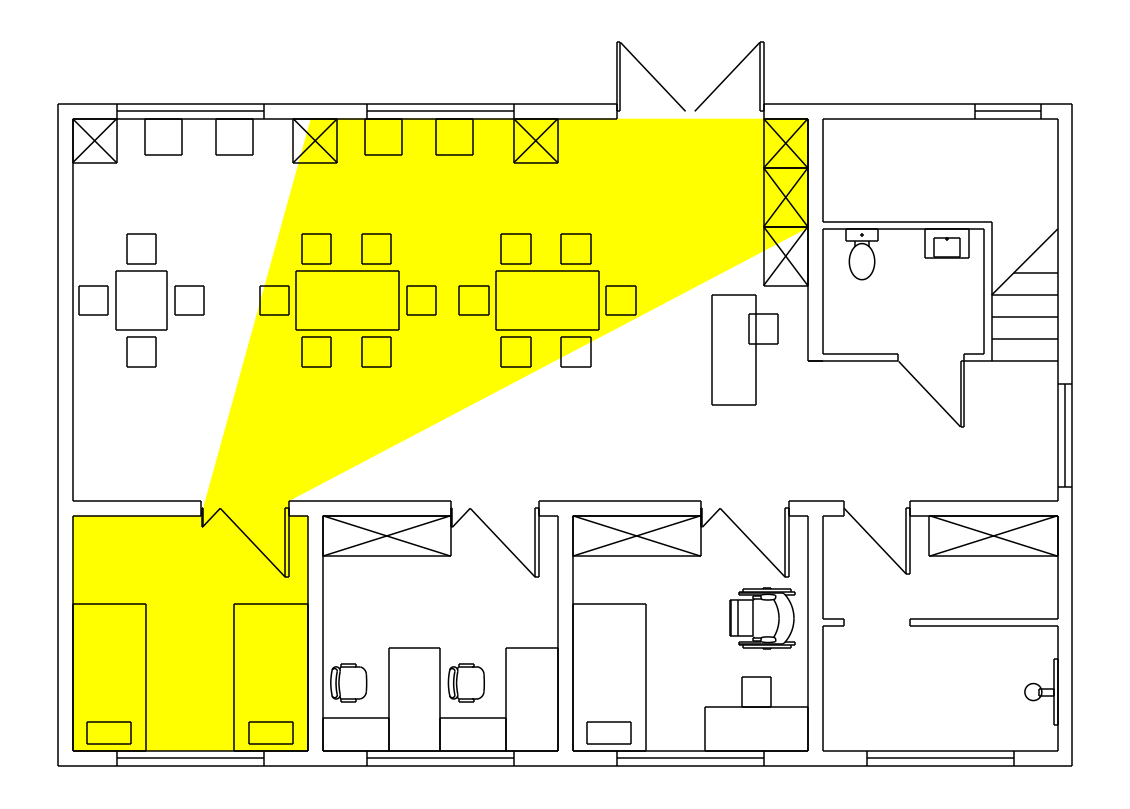

In [7]:
# select any objects to plot their isovists to check if results are valid

# input the id of the object to plot
OBJ_ID = 'B1'

fig,ax = plt.subplots(figsize=(20,20))
ax.axis('off')
ax.set_aspect('equal')

Annot.plot(ax=ax, edgecolor='black')
iso_dict[OBJ_ID].plot(ax=ax, color='yellow')

In [8]:
# convert iso_dict to GeoDF and save it
iso_GDF = iso_dict[BS[obj_id][0]]

for i in BS[obj_id][1:]:
    iso_GDF =  iso_GDF.append(iso_dict[i])
    
# save results as .gpkg(geopackage) file
iso_GDF.to_file(f'Data/{faci}_iso_BS.gpkg', driver='GPKG')

iso_GDF

,geometry,Depthmap_Ref,Connectivity,whose_iso
0,"POLYGON ((5113.071 1104.744, 5113.071 -200.000...",0,0.0,B1
0,"POLYGON ((5113.071 -1205.431, 5113.071 -1478.8...",0,0.0,B2
0,"POLYGON ((8713.071 -2095.256, 8713.071 1104.74...",0,0.0,B3
0,"POLYGON ((1913.071 -573.062, 1913.071 -523.876...",0,0.0,S1
0,"POLYGON ((7400.000 -2095.256, 7200.000 -2095.2...",0,0.0,S2
0,"POLYGON ((1913.071 -1784.966, 1913.071 -452.69...",0,0.0,S3
0,"POLYGON ((1913.071 -1157.843, 1913.071 -200.54...",0,0.0,S4
0,"POLYGON ((14413.071 3204.744, 14413.071 3204.7...",0,0.0,S5
0,"POLYGON ((14413.071 3204.744, 15313.071 3204.7...",0,0.0,S6
0,"POLYGON ((1913.071 1304.744, 1913.071 6200.000...",0,0.0,S7


## Visual links generation

- Generate visual links between beds and seats, based on whether A's isovist intersects or covers B's geometry.
- The generated links are directed links, with sources and targets specified.

In [9]:
# import isovist of all seats and beds
iso_GDF = geopandas.read_file(f'Data/{faci}_iso_BS.gpkg')
iso_GDF.crs=''

# load vga point map and convert to GDF
pointMapData = pd.read_csv(f"data/{faci}_VGA_pointmap.csv")
pointMapData = pointMapData[['Ref','x','y','Connectivity']]
# convert DF to GeoDF(point) using 'x' and 'y' as coordinates
dmp = geopandas.GeoDataFrame(
    pointMapData,
    geometry=geopandas.points_from_xy(
        pointMapData['x'],pointMapData['y']
    )
)


# specify which point is within which object's isovist
for i in iso_GDF['whose_iso']:
    dmp['in_iso_'+str(i)] = dmp.intersects(iso_GDF.loc[iso_GDF['whose_iso']==i,:].geometry.unary_union)

# specify which point is within which object
for i in BS[obj_id]:
    dmp['in_'+str(i)] = dmp.intersects(BS.loc[BS[obj_id]==i,:].geometry.unary_union)
    
dmp

,Ref,x,y,Connectivity,geometry,in_iso_B1,in_iso_B2,in_iso_B3,in_iso_S1,in_iso_S2,...,in_S11,in_S12,in_S13,in_S14,in_S15,in_S16,in_S17,in_S18,in_S19,in_S20
0,0,2000,-2000,515,POINT (2000.000 -2000.000),True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2000,-1800,521,POINT (2000.000 -1800.000),True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,2000,-1600,524,POINT (2000.000 -1600.000),True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,2000,-1400,534,POINT (2000.000 -1400.000),True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,2000,-1200,540,POINT (2000.000 -1200.000),True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,4325398,15200,2400,999,POINT (15200.000 2400.000),False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2611,4325399,15200,2600,925,POINT (15200.000 2600.000),False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2612,4325400,15200,2800,853,POINT (15200.000 2800.000),False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2613,4325401,15200,3000,777,POINT (15200.000 3000.000),False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

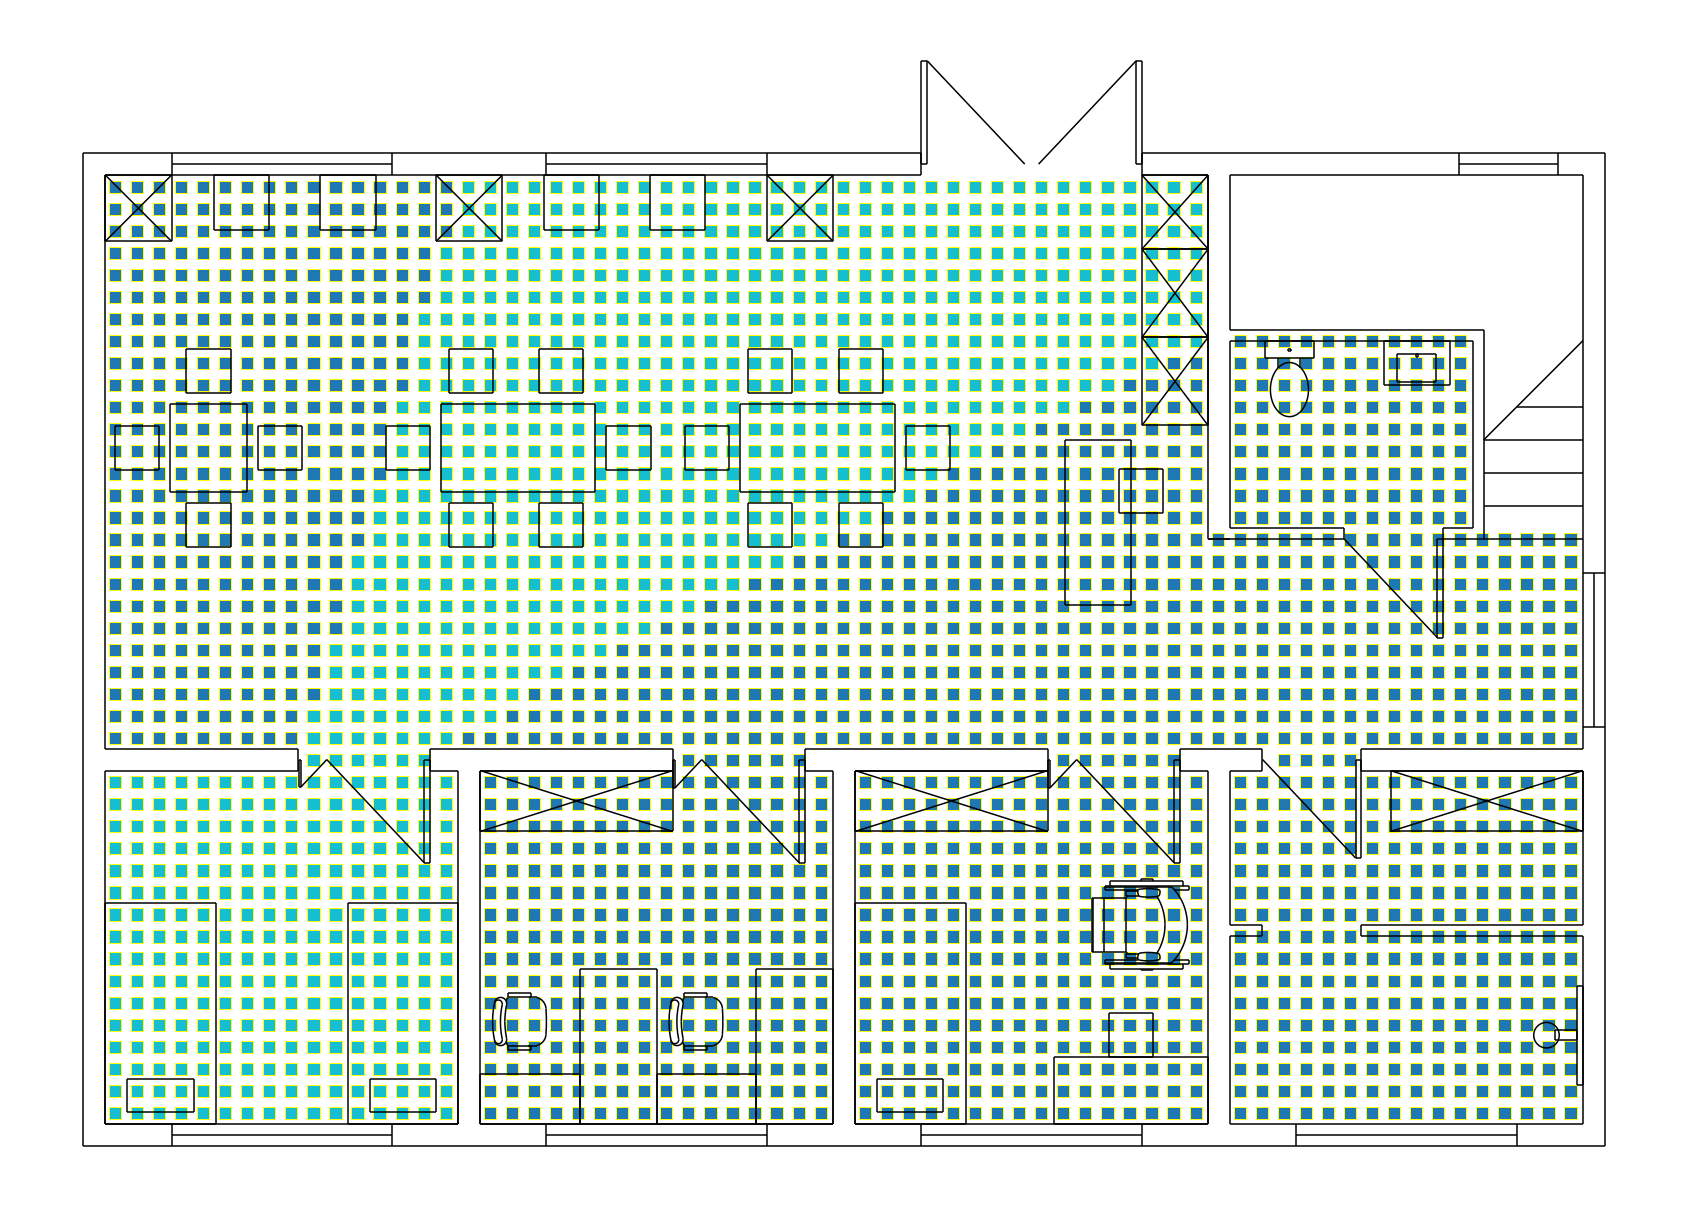

In [10]:
# plot and check result

# input the id of the seat to plot
plot_OBJID = 'B1'

fig,ax = plt.subplots(figsize=(30,30))
ax.axis('off')
ax.set_aspect('equal')

# Wall.plot(ax=ax, edgecolor='black', color = 'black')
Annot.plot(ax=ax, edgecolor='black')
dmp.plot(ax=ax, edgecolor='yellow', column=f'in_iso_{plot_OBJID}', marker='s', markersize = 150)

In [11]:
# specify (directed) links between seats based on visibility and
# save as an edge table

obj_li = BS[obj_id].unique().tolist()

dic_link = {}
for s in obj_li:
    vis_obj = []
    # all vga points within the isovist of obj i
    vis_points = dmp.loc[dmp['in_iso_'+str(s)]==True,:]
    for t in [i for i in obj_li if i != s]:
        if (vis_points.loc[vis_points['in_'+t]==True,:].shape[0])>0:
            vis_obj.append(t)
    dic_link[s] = vis_obj
    
df_link = pd.DataFrame(
    dict([(k,pd.Series(v)) for k,v in dic_link.items()])
).melt().dropna()
df_link.rename({'variable':'source','value':'target'},axis=1,inplace=True)

# save edge table
df_link.to_csv(f'Data/{faci}_links.csv')
df_link 

C:\Users\LXM\AppData\Local\Temp/ipykernel_26752/3440755034.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dict([(k,pd.Series(v)) for k,v in dic_link.items()])


,source,target
0,B1,B2
1,B1,S1
2,B1,S2
3,B1,S3
4,B1,S4
...,...,...
477,S20,S15
478,S20,S16
479,S20,S17
480,S20,S18


# Create and visualise networks

## Visualise networks

In [12]:
# Specify types of visual links (e.g., between beds and seats), and
# create graph object


faci = 'F1'  # facility name
# specify link types
# BS for links between beds and seats; SS for links between seats; BB for links between beds
link_type = 'BS' 


# load links and select link types
df_link = pd.read_csv(f'Data/{faci}_links.csv',index_col=0)
# specify link types
df_link['link_type'] = df_link.apply(lambda row:row['source'][0]+row['target'][0],axis=1)
if link_type == 'BB':
    df_link = df_link.loc[df_link['link_type']==link_type,:]
if link_type == 'SS':
    df_link = df_link.loc[df_link['link_type']==link_type,:]
if link_type == 'BS':
    df_link = df_link.loc[(df_link['link_type']=='BS')|(df_link['link_type']=='SB'),:]
df_link.drop('link_type',axis=1,inplace=True)


# create graph obj from links
DiG = nx.from_pandas_edgelist(
    df_link,
    source='source',
    target='target',
    create_using=nx.DiGraph()
)


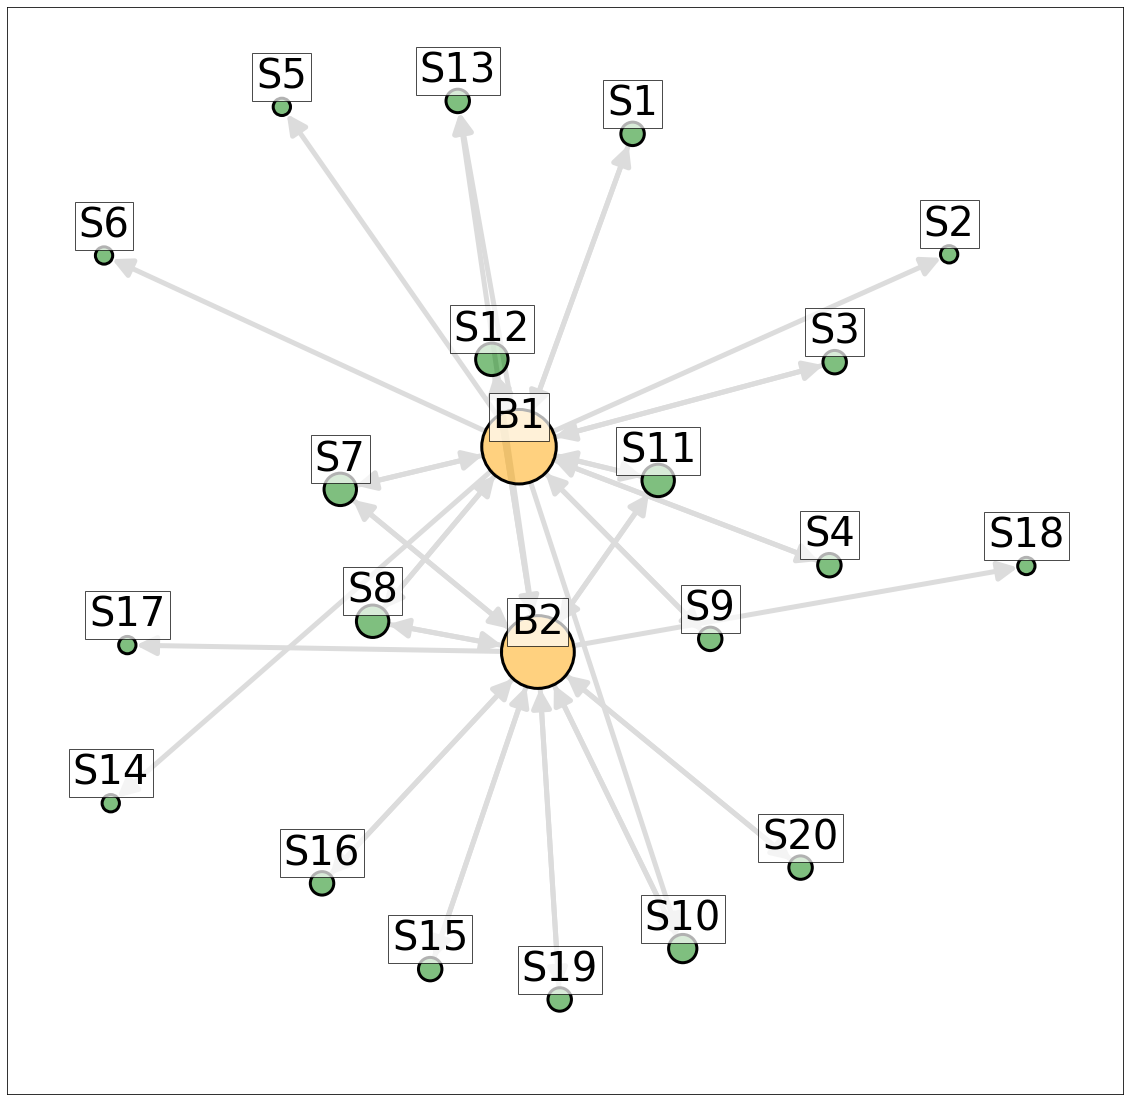

In [13]:

# stype parameters: node size and node colour
node_color_dic = {'B':(1,0.647,0,0.5),'S':(0, 0.502, 0,0.5)}
node_shape_dic = {'B':'s','S':'o'}

node_color = [node_color_dic[u[0]] for u,v in DiG.degree()]
node_degr = [v*250+50 for u,v in DiG.degree()]

# specify graph layout
pos = nx.spring_layout(DiG,k=0.85)

# define a function to shift label positions
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}


plt.figure(figsize=(20,20))


nx.draw_networkx_nodes(
    DiG,pos,
    node_size=node_degr, # size nodes based on degree
    node_color=node_color, # colour nodes based on bed or seat
    edgecolors='black',
    linewidths=3
)
nx.draw_networkx_labels(
    DiG,
    nudge(pos,0, 0.1),
    font_size=40,
    horizontalalignment='center',
    verticalalignment='top',
    bbox={"ec": "k", "fc": "white", "alpha": 0.7}
)
nx.draw_networkx_edges(
    DiG,pos,
    width=5,
    edge_color='gainsboro',
    arrowsize=40,
    node_size=node_degr
    # connectionstyle='arc3, rad=0.05'
)

# save figure
plt.savefig(
    f'Output_Figs/{faci}_links_{link_type}_graph.jpg',
    dpi=300
)

## Visualise networks on building layout plans

In [14]:
# Specify types of visual links (e.g., between beds and seats), and
# create graph object


faci = 'F1'  # facility name
# specify link types
# BS for links between beds and seats; SS for links between seats; BB for links between beds
link_type = 'BS' 


# load links and select link types
df_link = pd.read_csv(f'Data/{faci}_links.csv',index_col=0)
# specify link types
df_link['link_type'] = df_link.apply(lambda row:row['source'][0]+row['target'][0],axis=1)
if link_type == 'BB':
    df_link = df_link.loc[df_link['link_type']==link_type,:]
if link_type == 'SS':
    df_link = df_link.loc[df_link['link_type']==link_type,:]
if link_type == 'BS':
    df_link = df_link.loc[(df_link['link_type']=='BS')|(df_link['link_type']=='SB'),:]
df_link.drop('link_type',axis=1,inplace=True)


# create graph obj from links
DiG = nx.from_pandas_edgelist(
    df_link,
    source='source',
    target='target',
    create_using=nx.DiGraph()
)

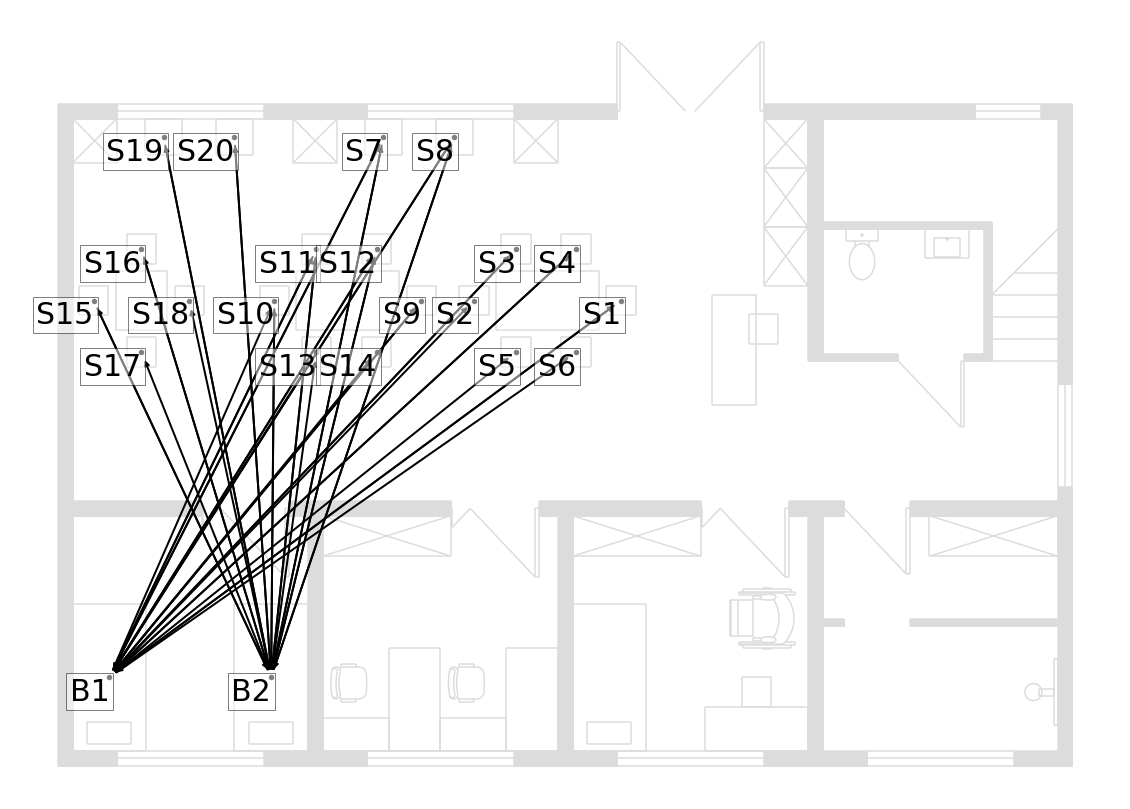

In [15]:
# plot graph on building layout

# define a function to shift label positions
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}


# load base maps
Wall = geopandas.read_file(f'Data/{faci}_wall.gpkg')
Annot = geopandas.read_file(f'Data/{faci}_annot.gpkg')
BS = geopandas.read_file(f'data/{faci}_BS.gpkg')

# generate obj centroids as node coord
coord_li = BS.apply(lambda x: x['geometry'].centroid.coords[0],axis=1) # get centroid coords
pos = dict(zip(BS['OID'],coord_li)) # combine coords with seat id


# plotting
fig,ax = plt.subplots(figsize=(20,20))
ax.axis('off')
ax.set_aspect('equal')

nx.draw_networkx_nodes(
    DiG,pos,
    # with_labels=True,
    node_size=20,
    node_color='black',
    ax=ax
)
nx.draw_networkx_labels(
    DiG,
    nudge(pos,0.9, 0.9),
    font_size=30,
    horizontalalignment='right',
    verticalalignment='top',
    bbox={"ec": "k", "fc": "white", "alpha": 0.5},
    ax=ax
)
nx.draw_networkx_edges(
    DiG,pos,
    width=2,
    edge_color='black',
    arrowsize=10,
    # connectionstyle='arc3, rad=0.05'
     ax=ax
)

# plot basemap
Wall.plot(ax=ax, edgecolor='gainsboro', color = 'gainsboro', zorder=0)
Annot.plot(ax=ax, edgecolor='gainsboro', aspect=1,zorder=0)


# save figure
plt.savefig(
    f'Output_Figs/{faci}_links_{link_type}_layout.jpg',
    dpi=300
)